In [ ]:
#importamos las librerias necesarias
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import variation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [ ]:
#El primer paso es descargar el archivo, guardarlo en drive y finalmente leerlo con pd.read_csv.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#instanciamos el dataset
df = pd.read_csv('/content/drive/MyDrive/DataSets/healthcare-dataset-stroke-data.csv')

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
nan_counts = df.isnull().sum()
print(nan_counts)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


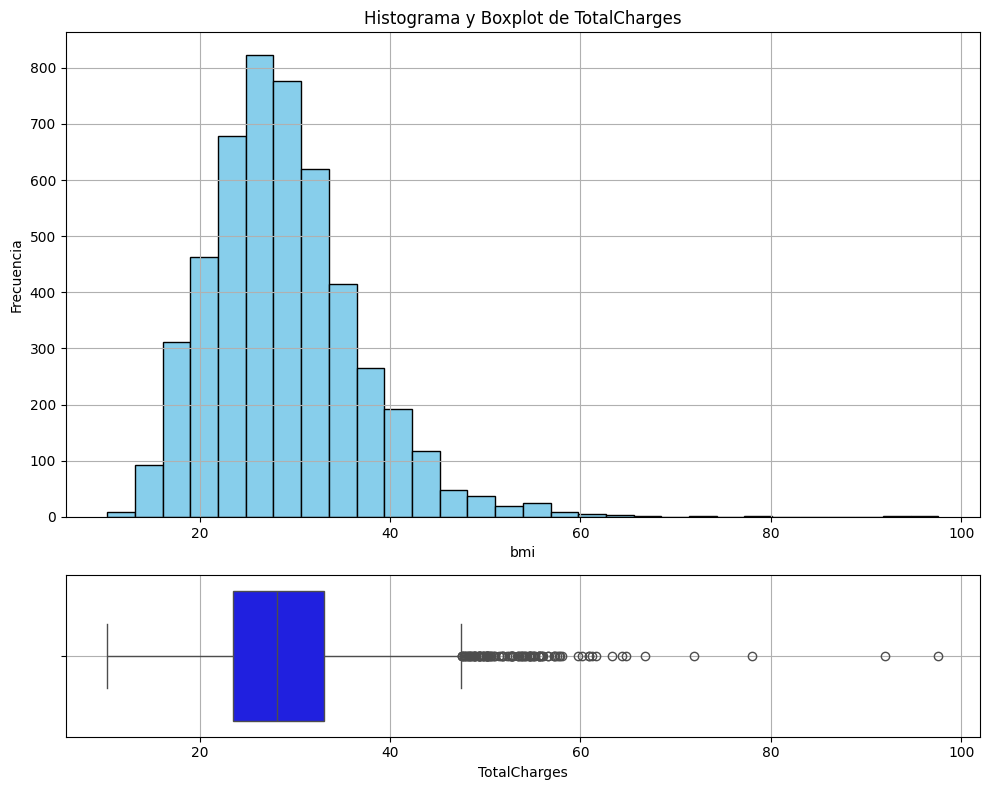

In [ ]:
# Filtrar valores nulos para evitar errores
df_clean = df['bmi'].dropna()

# Crear figura y subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Histograma
axes[0].hist(df_clean, bins=30, edgecolor='black', color='skyblue')
axes[0].set_xlabel('bmi')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Histograma y Boxplot de TotalCharges')
axes[0].grid(True)

# Boxplot
sns.boxplot(x=df_clean, color='blue', ax=axes[1])
axes[1].set_xlabel('TotalCharges')
axes[1].grid(True)

# Ajustar espacio entre subplots
plt.tight_layout()
plt.show()

In [ ]:
#Rellena con la mediana los valores NAN
mean_value = df['bmi'].mean()
df['bmi'].fillna(mean_value, inplace=True)

<ipython-input-52-b3045dbcbcb1>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(mean_value, inplace=True)


In [ ]:
nan_counts = df.isnull().sum()
print(nan_counts)

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [ ]:
def plot_boxplots(df):
    # Filtrar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No hay columnas numéricas en el DataFrame.")
        return

    # Definir el número de columnas y calcular las filas necesarias
    num_cols = 3
    num_rows = math.ceil(len(numeric_cols) / num_cols)

    # Configuración del tamaño de la figura
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil iteración

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    # Eliminar los ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

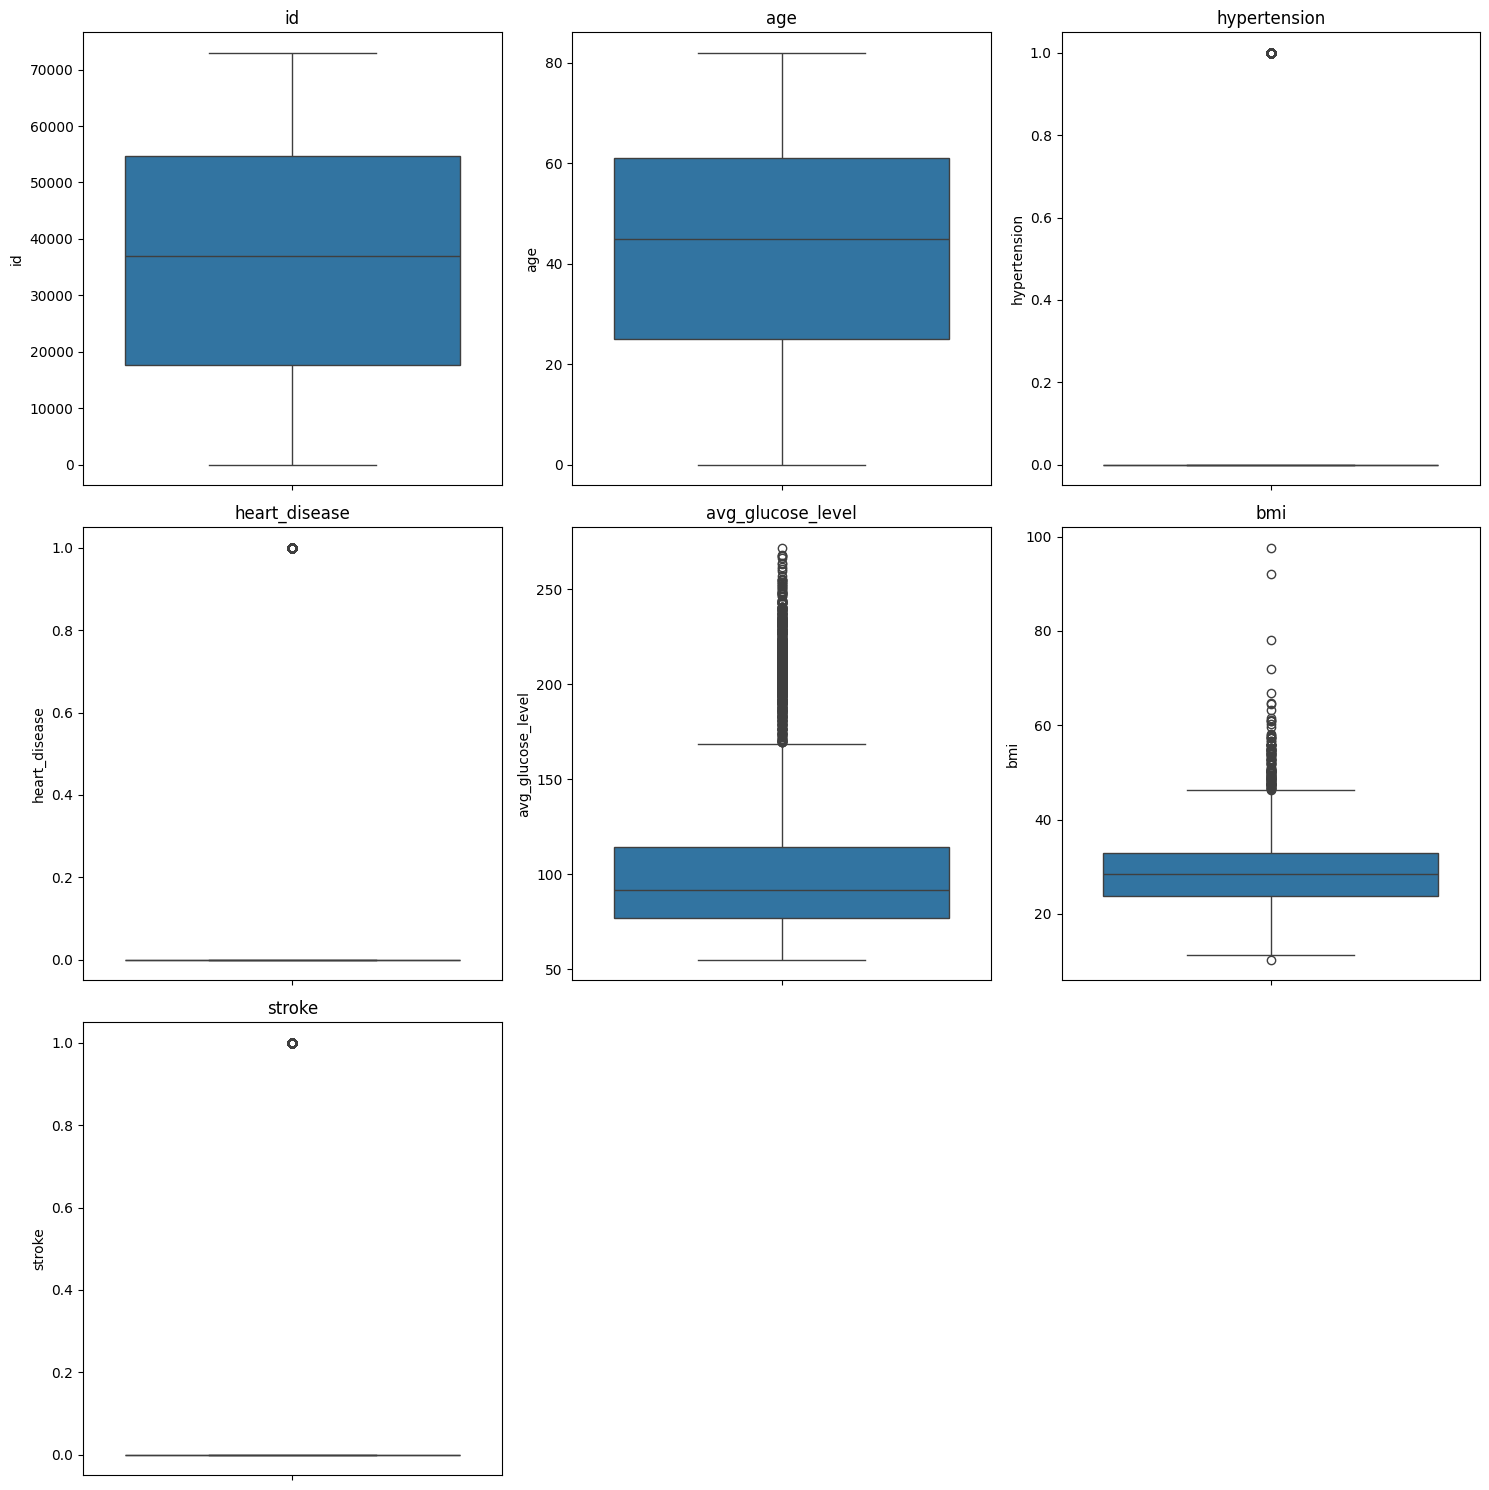

In [ ]:
plot_boxplots(df)

In [ ]:
def plot_histograms(df):
    # Filtrar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No hay columnas numéricas en el DataFrame.")
        return

    num_cols = 3
    num_rows = math.ceil(len(numeric_cols) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil iteración

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])  # kde=True agrega una línea de densidad
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    # Elimina los ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

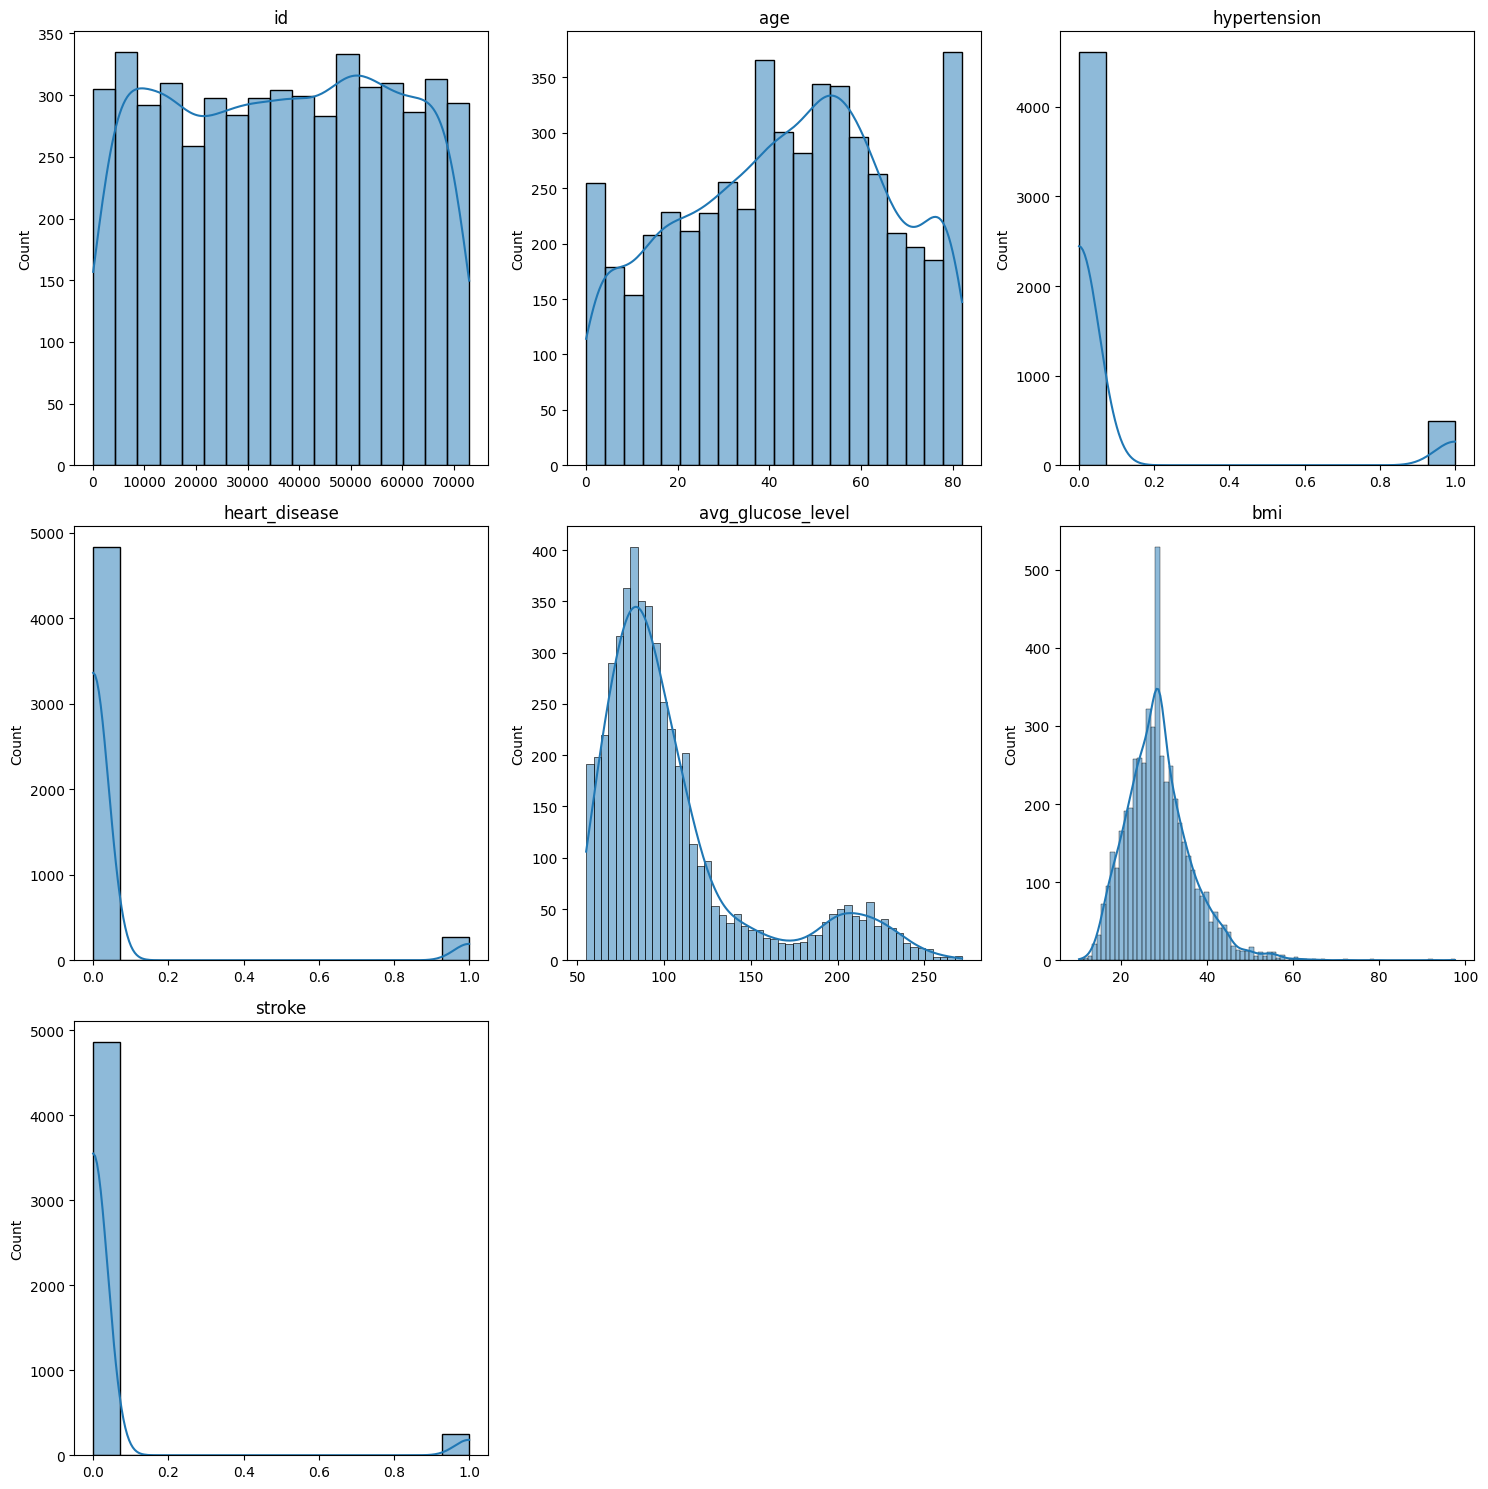

In [ ]:
plot_histograms(df)

In [ ]:
from math import ceil
def graficos_eda_categoricos(cat, columnas_excluir=[]):
    # Filtrar el DataFrame para excluir las columnas numéricas y las especificadas
    cat = cat.drop(columns=columnas_excluir)  # Excluir las columnas manualmente
    cat = cat.select_dtypes(exclude=['number'])  # Excluir las columnas numéricas

    filas = ceil(cat.shape[1] / 3)
    f, ax = plt.subplots(nrows=filas, ncols=3, figsize=(12, filas * 3))
    ax = ax.flat

    # Crea los gráficos de barras para cada columna
    for cada, variable in enumerate(cat.columns):
        cat[variable].value_counts().plot.barh(ax=ax[cada], color='skyblue')
        ax[cada].set_title(variable, fontsize=10, fontweight="bold")  # Fuente más pequeña
        ax[cada].tick_params(labelsize=8)  # Ajustamos el tamaño de las etiquetas

    # Ajusta el layout para evitar superposición
    plt.tight_layout()
    plt.show()

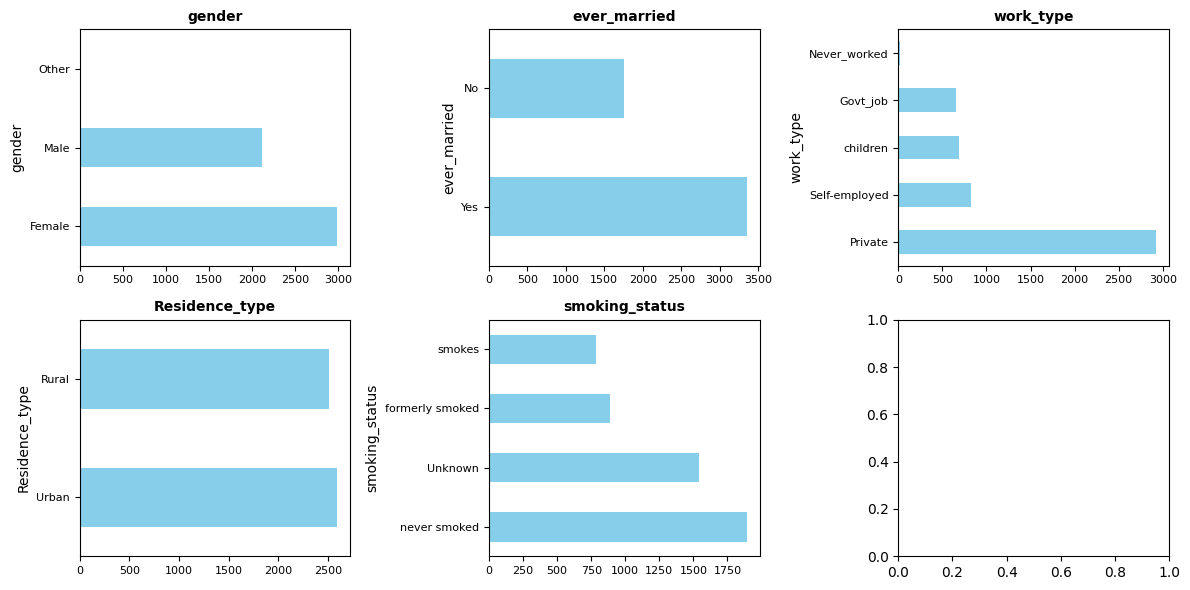

In [ ]:
graficos_eda_categoricos(df)

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [ ]:
columnas_a_cambiar = ['hypertension', 'heart_disease', 'stroke']
df[columnas_a_cambiar] = df[columnas_a_cambiar].replace({0: 'No', 1: 'Yes'})
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.600000,formerly smoked,Yes
1,51676,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Yes
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.500000,never smoked,Yes
3,60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.400000,smokes,Yes
4,1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 479.2+ KB


In [ ]:
df['age'] = df['age'].astype(int)
df['age'].unique()

array([67, 61, 80, 49, 79, 81, 74, 69, 59, 78, 54, 50, 64, 75, 60, 57, 71,
       52, 82, 65, 58, 42, 48, 72, 63, 76, 39, 77, 73, 56, 45, 70, 66, 51,
       43, 68, 47, 53, 38, 55,  1, 46, 32, 14,  3,  8, 37, 40, 35, 20, 44,
       25, 27, 23, 17, 13,  4, 16, 22, 30, 29, 11, 21, 18, 33, 24, 34, 36,
        0, 41,  5, 26, 31,  7, 12, 62,  2,  9, 15, 28, 10, 19,  6])

In [ ]:
# Paso 1: Calcular el promedio de la columna 'age', excluyendo los valores 0
promedio_age = df[df['age'] != 0]['age'].mean()

# Paso 2: Reemplazar los valores 0 por el promedio calculado
df['age'] = df['age'].replace(0, promedio_age)

In [ ]:
df['age'] = df['age'].astype(int)
df['age'].unique()

array([67, 61, 80, 49, 79, 81, 74, 69, 59, 78, 54, 50, 64, 75, 60, 57, 71,
       52, 82, 65, 58, 42, 48, 72, 63, 76, 39, 77, 73, 56, 45, 70, 66, 51,
       43, 68, 47, 53, 38, 55,  1, 46, 32, 14,  3,  8, 37, 40, 35, 20, 44,
       25, 27, 23, 17, 13,  4, 16, 22, 30, 29, 11, 21, 18, 33, 24, 34, 36,
       41,  5, 26, 31,  7, 12, 62,  2,  9, 15, 28, 10, 19,  6])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 479.2+ KB


In [ ]:
# ESCALADORES
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Standard Scaler
escalador = StandardScaler()
df[numeric_cols] = escalador.fit_transform(df[numeric_cols]) # Tomar valores numericos'''